In [1]:
# Imports 
import pandas as pd
from datetime import datetime
import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import plotly.express as px
from scipy import stats


#for LDA:
import gzip
import tarfile
import xml.etree.ElementTree as ET
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

colors = [
    "#FF6B6B", "#F4A261", "#2A9D8F", "#264653", "#E9C46A", "#E76F51", "#A8DADC", "#457B9D", "#1D3557", "#FFE8D6", 
    "#FFB4A2",  
    "#CB997E",  
    "#A5A58D",  
    "#6D6875",  
    "#B5838D",  
    "#81B29A",  
    "#F2CC8F",  
    "#606C38" 
]

import random
seed = 42
random.seed(seed)
np.random.seed(seed)

focus_countries = ['United States of America', 'India', 'United Kingdom', 'Japan', 'Argentina', 'Iran']

color_dict = dict(zip(focus_countries, colors))

In [2]:
DATA_PATH = 'data'
df_date_clean = pd.read_csv(DATA_PATH + '/df_date_clean.csv')
df_date_clean['Movie genres'] = df_date_clean['Movie genres'].str.lower().str.strip() # a faire plutot dans la fcto qui fait df_date_clean
df_date_clean.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie country,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001,14010832.0,98.0,['English Language'],United States of America,thriller
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,['English Language'],United States of America,mystery
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,['Norwegian Language'],Norway,crime fiction
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,['English Language'],United Kingdom,thriller
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,['German Language'],Germany,drama


In [3]:
weak_verbs = {
    "accept", "achieve", "act", "add", "admit", "affect", "afford", "agree", "aim", "allow", "appear", "apply", "argue",
    "arrange", "arrive", "ask", "assume", "avoid", "be", "become", "begin", "believe", "belong", "bring", "build", "buy", "call",
    "carry", "cause", "change", "choose", "claim", "close", "collect", "come", "commit", "compare", "complete",
    "consider", "consist", "continue", "contribute", "control", "cope", "create", "cut", "deal", "decide", "decline",
    "deliver", "demand", "depend", "describe", "design", "determine", "develop", "differ", "discover",
    "discuss", "display", "do", "draw", "dress", "drink", "drive", "eat", "encourage", "end", "enjoy",
    "enter", "establish", "examine", "exist", "expect", "experience", "explain", "express", "fail", "fall", "feel",
    "find", "follow", "form", "function", "gain", "get", "give", "go", "grow", "guess", "handle", "happen",
    "have", "hear", "help", "hold", "hope", "identify", "imagine", "implement", "improve", "include", "increase",
    "influence", "inform", "initiate", "insist", "intend", "introduce", "involve", "join", "keep","kill", "know",
    "lead", "learn", "leave", "let", "like", "listen", "live", "look", "lose", "maintain",
    "make" , "manage", "matter", "mean", "measure", "meet", "mention", "mind", "miss", "move", "need","new", "note", "notice",
    "observe", "obtain", "occur", "offer", "open", "operate", "organize", "other", "own", "participate", "pass", "pay", "perform",
    "plan", "play", "possess", "prefer", "prepare", "present", "prevent", "proceed", "produce", "provide", "pull", "put",
    "raise", "reach", "read", "realize", "receive", "recognize", "record", "reduce", "refer", "reflect", "refuse",
    "regard", "relate", "remain", "remember", "remove", "report", "represent", "require", "resolve", "respond",
    "result", "reveal", "rise", "run", "save", "say", "see", "seem", "select", "sell", "send", "serve", "set", "share",
    "show", "sit", "sleep", "solve", "speak", "spend", "stand", "start", "state", "stay", "stop", "study", "suggest",
    "supply", "support", "suppose", "take", "talk", "teach", "tell", "tend", "test", "think", "touch",
    "train", "try", "turn", "understand", "use", "vary", "view", "visit", "wait", "walk", "want", "watch", "wear",
    "win", "wish", "work", "write"
}
# function that extracts the meaningful words in each XML file
def parse_corenlp_file(file):
    with gzip.open(file, 'rt', encoding='utf-8') as f:
        tree = ET.parse(f)
        root = tree.getroot()
        filtered_words = []
        for token in root.iter('token'):
            lemma = token.find('lemma').text
            pos = token.find('POS').text
            if pos in {'NN', 'NNS'} or pos.startswith('VB') or pos.startswith('JJ'):
                if lemma.lower() not in weak_verbs:
                    filtered_words.append(lemma)
        return ' '.join(filtered_words)

In [4]:
tar_path = 'data/corenlp_plot_summaries.tar'

documents = []
ids = []


with tarfile.open(tar_path, 'r') as tar:
    for member in tar.getmembers():
        if member.name.endswith('.xml.gz'):
            with tar.extractfile(member) as xml_gz_file:
                film_id = member.name.split('/')[-1].replace('.xml.gz', '')
                film_id = int(film_id)
                ids.append(film_id)
                document = parse_corenlp_file(xml_gz_file)
                documents.append(document)

## General LDA analysis

In [5]:
#general dictionnary and corpus
tokenized_documents_general = [[word for word in doc.lower().split() if len(word) >= 2] for doc in documents]
dictionary_general = Dictionary(tokenized_documents_general)
max_freq = 0.3
min_wordcount = 5
dictionary_general.filter_extremes(no_below=min_wordcount, no_above=max_freq)
corpus_general = [dictionary_general.doc2bow(doc) for doc in tokenized_documents_general]

In [6]:
def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(
            corpus=corpus,
            num_topics=num_topics,
            id2word=dictionary,
            passes=10,
            workers=4,
            random_state=42,
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [7]:
start = 2
limit = 6
step = 1
models_general, coherences_general = compute_coherence_values(dictionary=dictionary_general, corpus=corpus_general, texts=tokenized_documents_general, start=start, limit=limit, step=step)

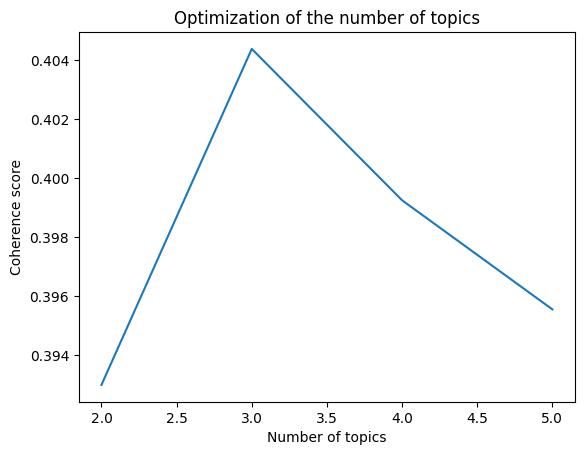

In [8]:
x = range(start, limit, step)
plt.plot(x, coherences_general)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.title("Optimization of the number of topics")
plt.show()

In [9]:
selected_coherences = np.max(coherences_general)
selected_models_general= models_general[np.argmax(coherences_general)]

In [10]:
top_themes_per_document = []
for i, doc in enumerate(corpus_general):
    doc_topics = selected_models_general.get_document_topics(doc, minimum_probability=0)
    sorted_doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)

    top_indices = [topic_id for topic_id, _ in sorted_doc_topics[:3]]
    top_proportions = [proportion for _, proportion in sorted_doc_topics[:3]]

    top_themes_per_document.append({
        "Wikipedia movie ID": ids[i],
        "Theme 1": top_indices[0],
        "Prop Theme 1": top_proportions[0],
    })

df_top_themes = pd.DataFrame(top_themes_per_document)

df_date_clean['Wikipedia movie ID'] = df_date_clean['Wikipedia movie ID'].astype(str)
df_top_themes['Wikipedia movie ID'] = df_top_themes['Wikipedia movie ID'].astype(str)
merged_df = pd.merge(df_date_clean, df_top_themes, on='Wikipedia movie ID', how='inner')

best_movies_per_theme = merged_df.loc[merged_df.groupby("Theme 1")["Prop Theme 1"].idxmax()]
best_movies_per_theme.head()

print(f"\nCoherence of the selected model: {selected_coherences}\n")
for idx, topic in selected_models_general.print_topics(-1):
    best_movie_data = best_movies_per_theme.loc[best_movies_per_theme['Theme 1'] == idx]
    movie_name = best_movie_data['Movie name'].values[0]
    proportion = best_movie_data['Prop Theme 1'].values[0]
    print(f"Topic {idx}: {topic}")
    print(f"Best representative movie: {movie_name} (Proportion: {proportion:.4f})")
print("\n\n")


Coherence of the selected model: 0.40438655270454094

Topic 0: 0.006*"attack" + 0.006*"escape" + 0.005*"return" + 0.004*"time" + 0.004*"force" + 0.004*"attempt" + 0.004*"group" + 0.004*"order" + 0.004*"ship" + 0.004*"fight"
Best representative movie: Eden Log (Proportion: 0.9988)
Topic 1: 0.011*"police" + 0.008*"car" + 0.007*"murder" + 0.007*"money" + 0.006*"house" + 0.006*"shoot" + 0.005*"escape" + 0.005*"gang" + 0.005*"friend" + 0.004*"name"
Best representative movie: Played (Proportion: 0.9982)
Topic 2: 0.013*"love" + 0.011*"father" + 0.010*"family" + 0.009*"friend" + 0.008*"mother" + 0.007*"marry" + 0.007*"day" + 0.006*"home" + 0.006*"time" + 0.006*"woman"
Best representative movie: The Pregnancy Pact (Proportion: 0.9981)





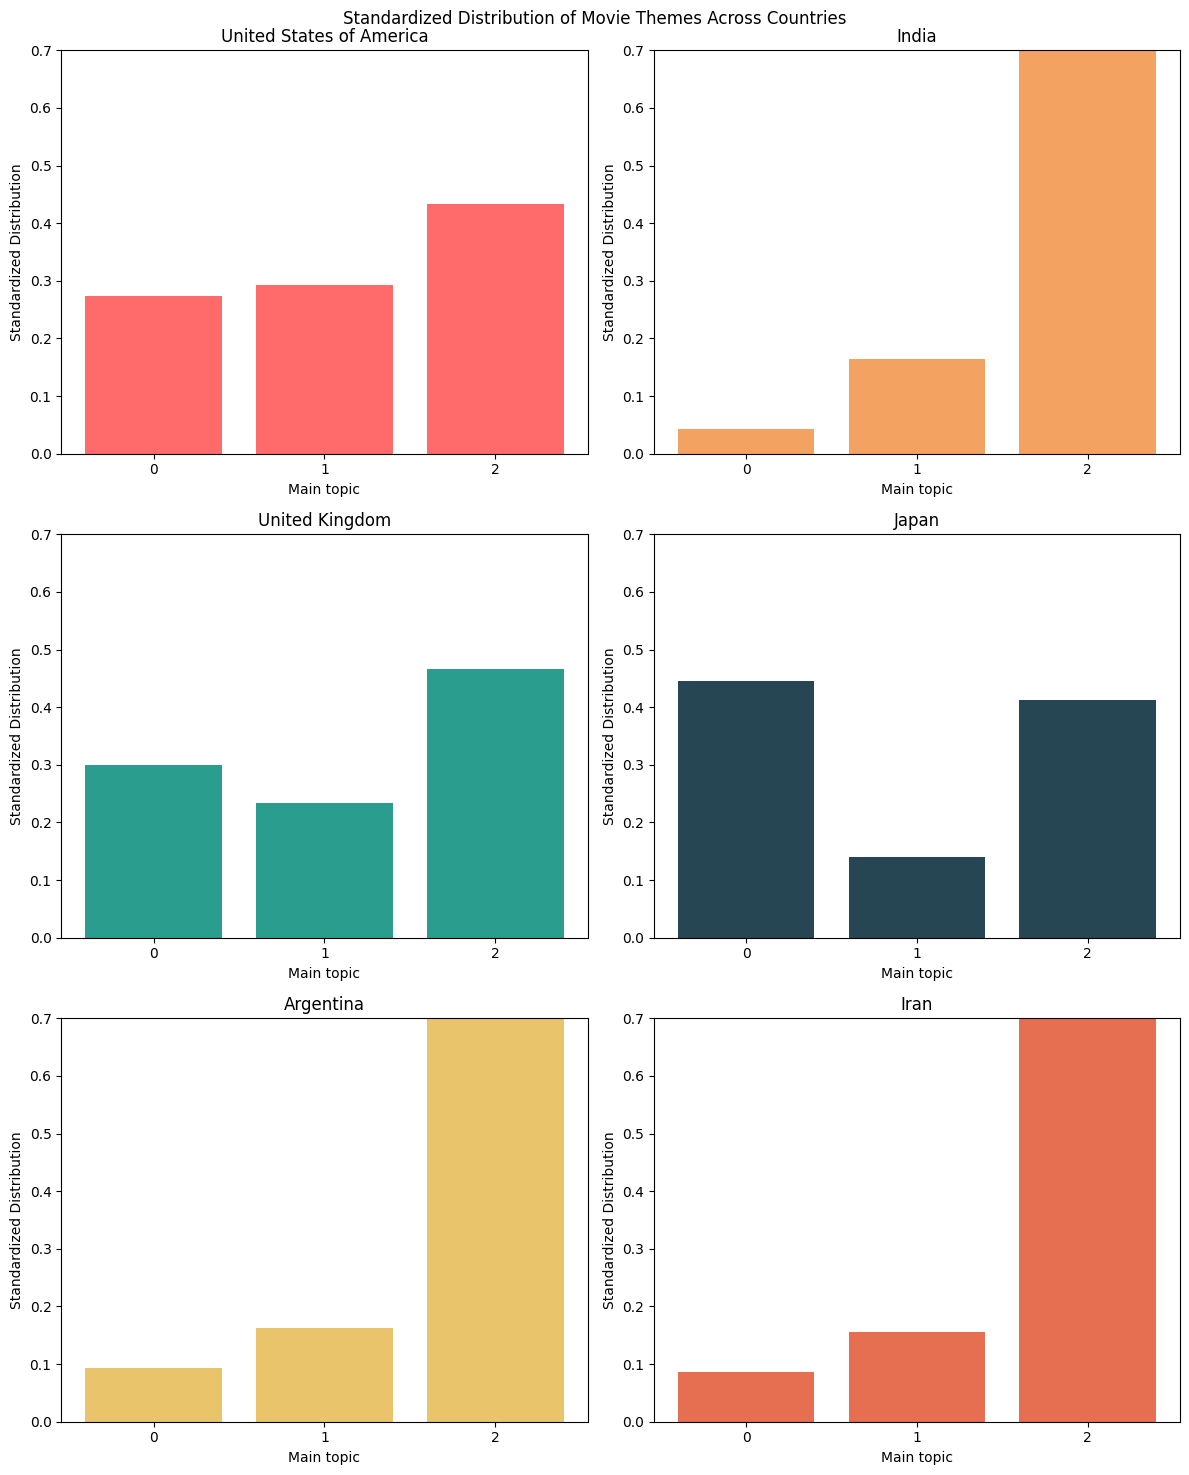

In [11]:
num_columns = 2
num_rows = 3
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 15))
fig.suptitle('Standardized Distribution of Movie Themes Across Countries')
axes = axes.flatten()

for idx, country in enumerate(focus_countries):
    movies = merged_df[merged_df['Movie country'] == country]
    theme_counts = movies['Theme 1'].value_counts()
    theme_counts_stand = theme_counts / theme_counts.sum()

    axes[idx].bar(theme_counts_stand.index, theme_counts_stand.values,color=color_dict[country])
    axes[idx].set_title(f"{country}")
    axes[idx].set_xlabel("Main topic")
    axes[idx].set_ylabel("Standardized Distribution")
    axes[idx].set_xticks(theme_counts_stand.index)  # Ensure theme indices show up correctly on x-axis
    axes[idx].set_xticklabels(theme_counts_stand.index)

for ax in axes:
    ax.set_ylim(0, 0.7)

plt.tight_layout()
plt.show()

## Specific on genre analysis

In [12]:
movie_genres=df_date_clean["Movie genres"].unique()
genre_documents = {genre: [] for genre in movie_genres}
ids_documents = {genre: [] for genre in movie_genres}
number_films_minimum = 1000 #treshold for the number of films

for i, doc in enumerate(documents):
    row = df_date_clean[df_date_clean['Wikipedia movie ID'].astype(int) == ids[i]]
    if not row.empty:
        genre = row['Movie genres'].iloc[0]
        genre_documents[genre].append(doc)
        ids_documents[genre].append(ids[i])
    else:
        # Skip if no matching row found
        continue

In [13]:
filter_genre_documents = {key: value for key, value in genre_documents.items() if len(value) > number_films_minimum}

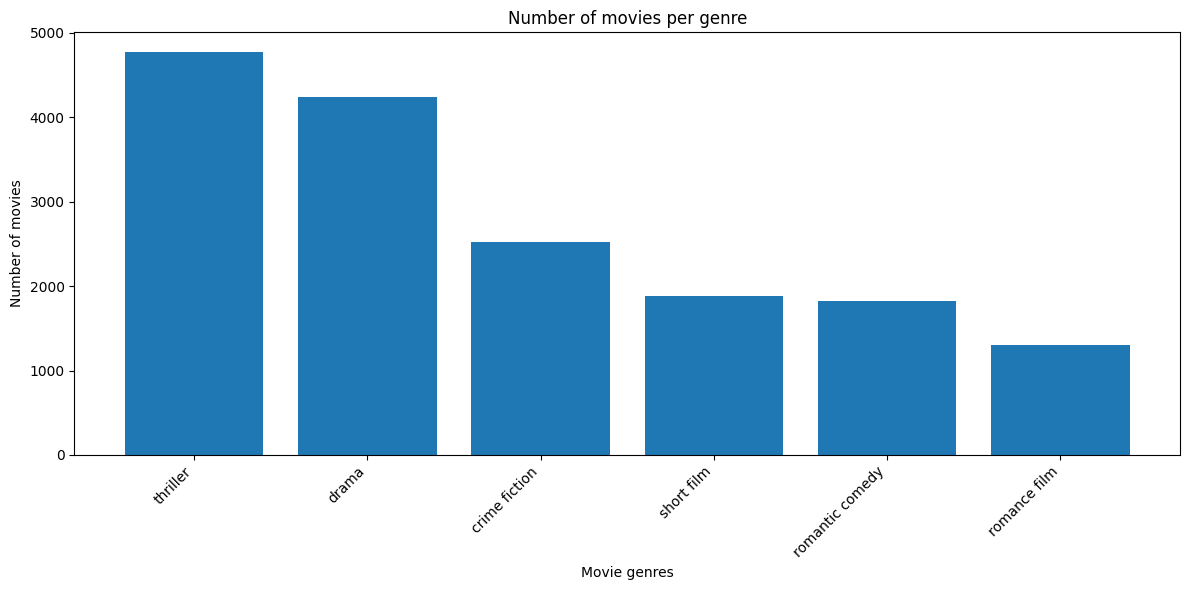

In [14]:
genre_counts = {genre: len(docs) for genre, docs in filter_genre_documents.items()}
genre_counts = dict(sorted(genre_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.bar(genre_counts.keys(), genre_counts.values())
plt.xlabel('Movie genres')
plt.ylabel('Number of movies')
plt.title('Number of movies per genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

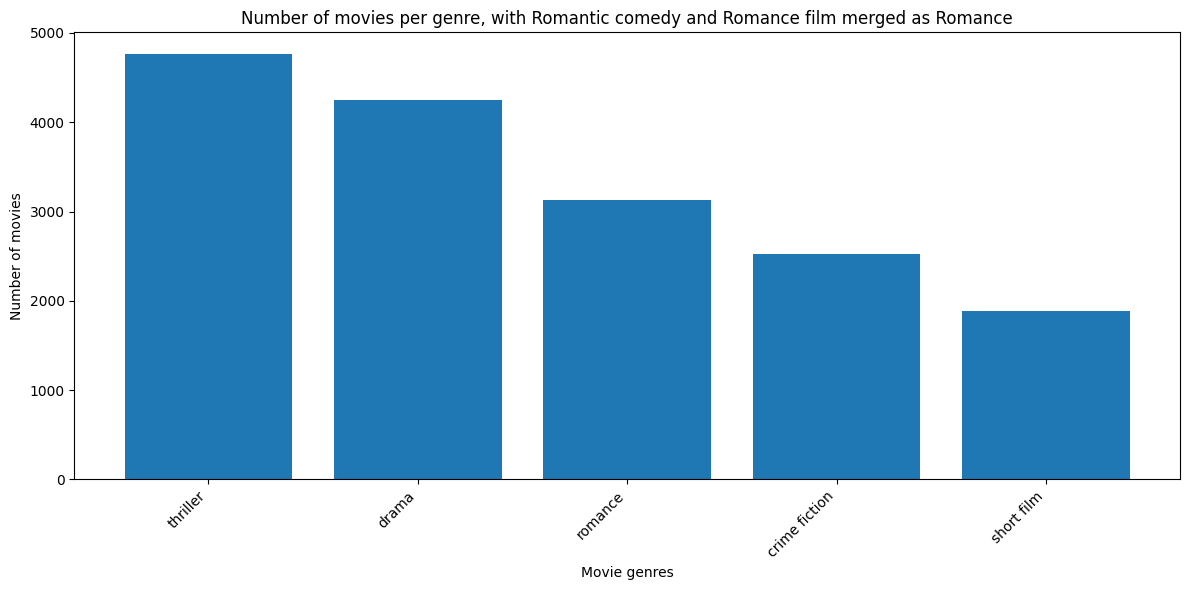

In [15]:
merged_genres = {}
merged_ids = {}
merged_genres['romance'] = []
merged_ids['romance'] = []

for genre, docs in filter_genre_documents.items():
    if genre in ['romantic comedy', 'romance film']:
        merged_genres['romance'].extend(docs)
        merged_ids['romance'].extend(ids_documents[genre])
    else:
        if genre not in merged_genres:
            merged_genres[genre] = []
            merged_ids[genre] = []
        merged_genres[genre].extend(docs)
        merged_ids[genre].extend(ids_documents[genre])


genre_counts2 = {genre: len(docs) for genre, docs in merged_genres.items()}
genre_counts2 = dict(sorted(genre_counts2.items(), key=lambda item: item[1], reverse=True))


plt.figure(figsize=(12, 6))
plt.bar(genre_counts2.keys(), genre_counts2.values())
plt.xlabel('Movie genres')
plt.ylabel('Number of movies')
plt.title('Number of movies per genre, with Romantic comedy and Romance film merged as Romance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

So we can study the topics in those top 3 genres: Thriller, Drama and Romance

In [16]:
top_3_genres = list(genre_counts2.keys())[:3]

top_3_genres_dict = {genre: merged_genres[genre] for genre in top_3_genres}
top_3_genres_ids = {genre: merged_ids[genre] for genre in top_3_genres}
print(top_3_genres_dict.keys())

dict_keys(['thriller', 'drama', 'romance'])


In [17]:
# Specific dictionnary and corpus per genres
genre_tokenized_documents = {genre: [] for genre in top_3_genres_dict}
genre_dictionary = {genre: [] for genre in top_3_genres_dict}
genre_corpus = {genre: [] for genre in top_3_genres_dict}
genre_models = {genre: [] for genre in top_3_genres_dict}

for genre in top_3_genres_dict:
    tokenized_documents = [[word for word in doc.lower().split() if len(word) >= 2] for doc in top_3_genres_dict[genre]]
    dictionary = Dictionary(tokenized_documents)
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)
    genre_tokenized_documents[genre] = tokenized_documents
    genre_dictionary[genre] = dictionary
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]
    genre_corpus[genre] = corpus

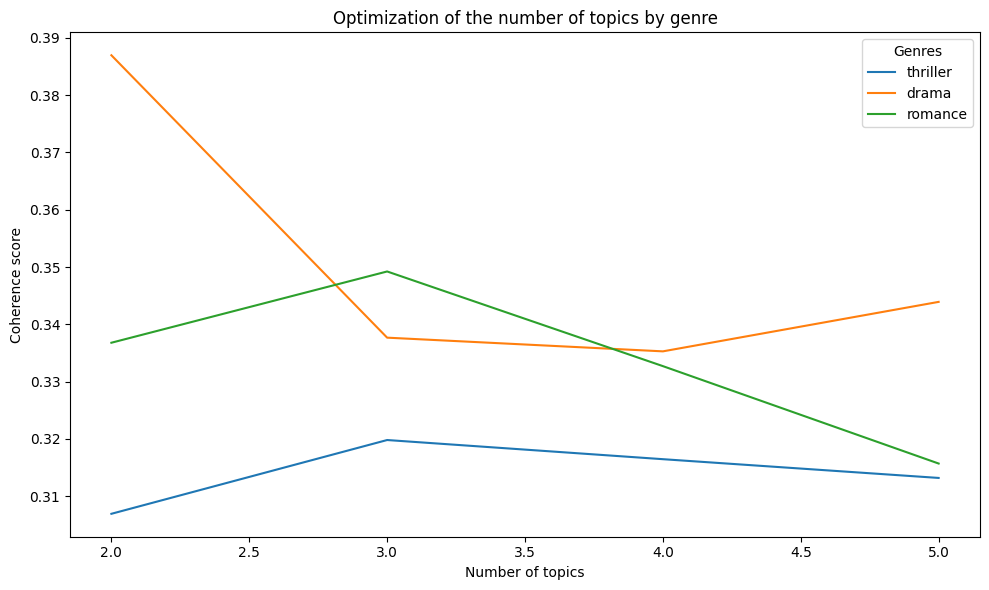

In [18]:
coherence_values = {genre: [] for genre in top_3_genres_dict}
plt.figure(figsize=(10, 6))
for genre in top_3_genres_dict:
    genre_models[genre], coherence_values[genre] = compute_coherence_values(dictionary=genre_dictionary[genre], corpus=genre_corpus[genre], texts=genre_tokenized_documents[genre], start=start, limit=limit, step=step)
    
for genre, values in coherence_values.items():
    plt.plot(x, values, label=genre)
    
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
plt.title("Optimization of the number of topics by genre")
plt.legend(title="Genres") 
plt.tight_layout()
plt.show()

In [19]:
selected_models = {}
selected_coherences = {}

for genre, models in genre_models.items():
    selected_coherences[genre] = np.max(coherence_values[genre])
    selected_models[genre] = models[np.argmax(coherence_values[genre])]


In [20]:
top_themes_per_document_by_genre = {}

for genre in top_3_genres:
    top_theme = []
    top_proportion = []
    model = selected_models[genre]
    corpus = genre_corpus[genre]

    for i, doc in enumerate(corpus):
        doc_topics = model.get_document_topics(doc, minimum_probability=0)
        top_topic = max(doc_topics, key=lambda x: x[1])
        top_theme.append(top_topic[0])
        top_proportion.append(top_topic[1])

    genre_df = pd.DataFrame({
        "Wikipedia movie ID": merged_ids[genre],
        "Theme 1": top_theme,
        "Prop Theme 1": top_proportion,
    })

    df_date_clean['Wikipedia movie ID'] = df_date_clean['Wikipedia movie ID'].astype(int)
    genre_df['Wikipedia movie ID'] = genre_df['Wikipedia movie ID'].astype(int)
    genre_df = pd.merge(df_date_clean, genre_df, on="Wikipedia movie ID", how="inner")
    top_themes_per_document_by_genre[genre] = genre_df
    print(f'Genre:{genre}')
    print(f"Coherence of the selected model: {selected_coherences[genre]}\n")
    for idx, topic in model.print_topics(-1):
        best_movie_data = genre_df.loc[genre_df['Theme 1'] == idx]
        movie_name = best_movie_data['Movie name'].values[0]
        proportion = best_movie_data['Prop Theme 1'].values[0]
        print(f"Topic {idx}: {topic}")
        print(f"Best representative movie: {movie_name} (Proportion: {proportion:.4f})\n")
    print("\n\n")


Genre:thriller
Coherence of the selected model: 0.31978761224118774

Topic 0: 0.006*"father" + 0.005*"attempt" + 0.005*"family" + 0.004*"attack" + 0.004*"agent" + 0.004*"order" + 0.004*"son" + 0.004*"name" + 0.004*"force" + 0.004*"day"
Best representative movie: Deadly Voyage (Proportion: 0.9588)

Topic 1: 0.007*"house" + 0.006*"attack" + 0.005*"body" + 0.005*"room" + 0.005*"mother" + 0.005*"die" + 0.005*"home" + 0.004*"woman" + 0.004*"child" + 0.004*"group"
Best representative movie: Ghosts of Mars (Proportion: 0.6688)

Topic 2: 0.009*"car" + 0.009*"shoot" + 0.006*"money" + 0.006*"house" + 0.006*"gun" + 0.005*"wife" + 0.005*"home" + 0.005*"woman" + 0.005*"name" + 0.004*"day"
Best representative movie: ...And Justice for All (Proportion: 0.9973)




Genre:drama
Coherence of the selected model: 0.3869772939194343

Topic 0: 0.011*"family" + 0.010*"love" + 0.010*"father" + 0.009*"mother" + 0.009*"man" + 0.008*"son" + 0.008*"daughter" + 0.007*"wife" + 0.007*"young" + 0.007*"woman"
Best rep

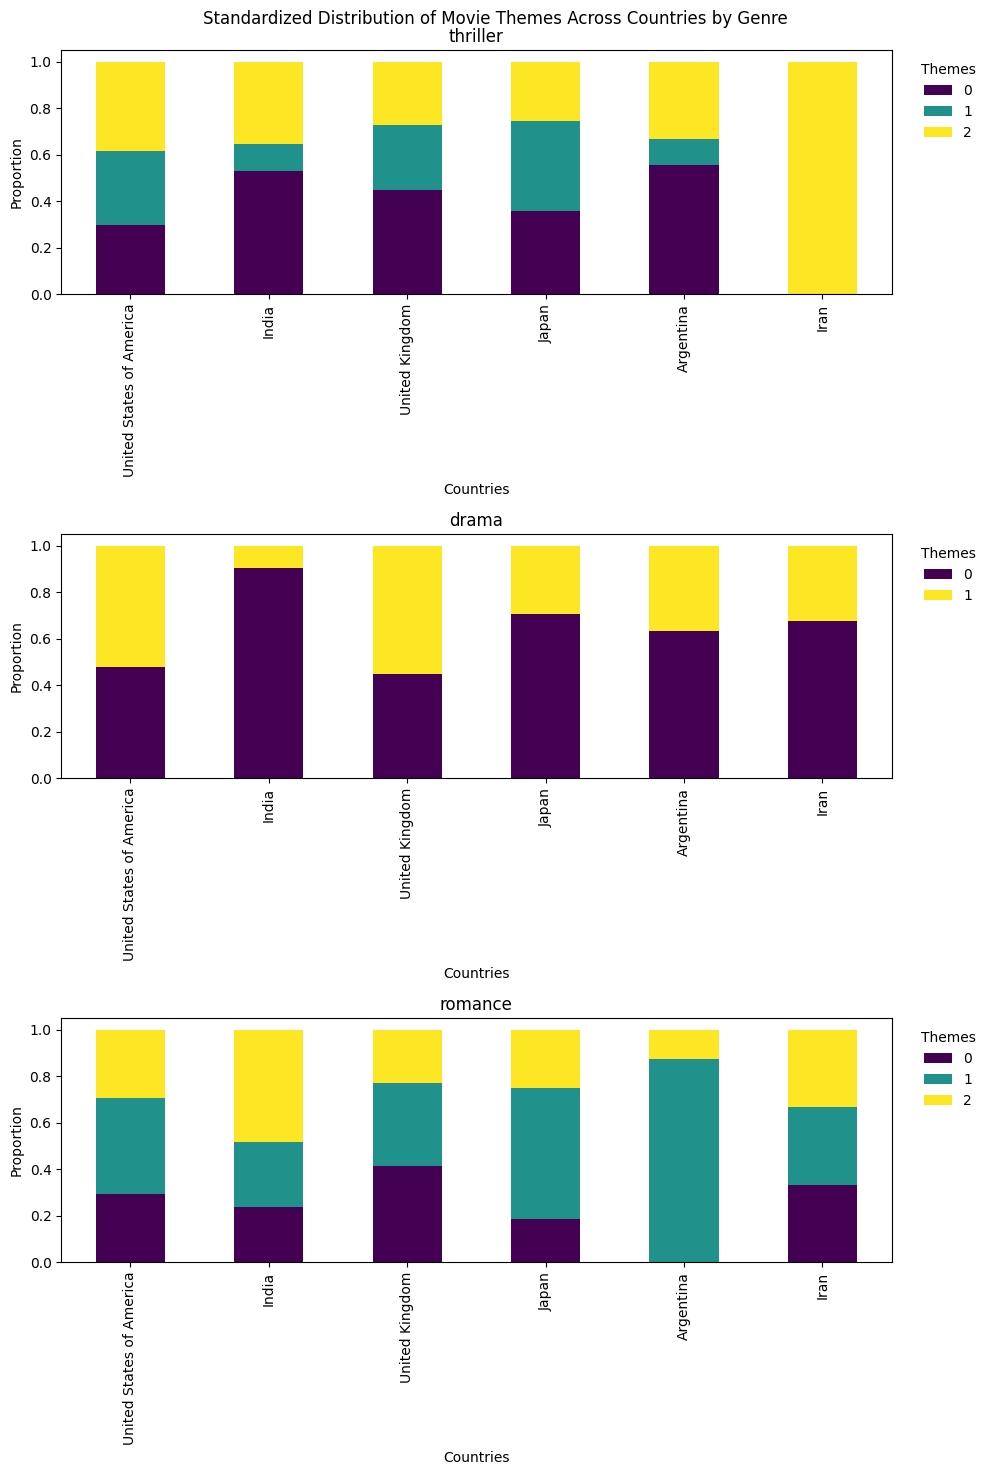

In [21]:
fig, axes = plt.subplots(len(selected_models), 1, figsize=(10, 5 * len(selected_models)))
fig.suptitle('Standardized Distribution of Movie Themes Across Countries by Genre')

for idx, genre in enumerate(selected_models):
    merged_df = top_themes_per_document_by_genre[genre]
    theme_data = merged_df[['Movie country', 'Theme 1']]
    theme_counts = theme_data.groupby(['Movie country', 'Theme 1']).size().unstack(fill_value=0)
    theme_proportions = theme_counts.div(theme_counts.sum(axis=1), axis=0)

    ax = axes[idx]
    theme_proportions.loc[focus_countries].plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
    ax.set_title(f"{genre}")
    ax.set_xlabel("Countries")
    ax.set_ylabel("Proportion")
    ax.legend(title="Themes", bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

In [22]:

figures = []

for genre in selected_models:
    merged_df = top_themes_per_document_by_genre[genre]
    theme_data = merged_df[['Movie country', 'Theme 1']]
    theme_counts = theme_data.groupby(['Movie country', 'Theme 1']).size().unstack(fill_value=0)
    theme_proportions = theme_counts.div(theme_counts.sum(axis=1), axis=0) * 100  # Convert to percentage
    
    # Filter for focus countries
    theme_proportions = theme_proportions.loc[focus_countries]
    
    # Reset index for Plotly compatibility
    theme_proportions.reset_index(inplace=True)
    melted_df = theme_proportions.melt(id_vars='Movie country', var_name='Theme', value_name='Percentage')
    
    # Create a stacked bar chart
    fig = px.bar(
        melted_df,
        x='Movie country',
        y='Percentage',
        color='Theme',
        title=f'Standardized Distribution of Movie Themes: {genre}',
        text_auto='.2f',
    )
    
    # Update layout to remove background
    fig.update_layout(
        plot_bgcolor="white",
        paper_bgcolor="white",
        xaxis_title="Countries",
        yaxis_title="Percentage (%)",
        legend_title="Themes",
        title_x=0.5
    )
    
    # Append to the figures list
    figures.append(fig)

# Show all figures
for fig in figures:
    fig.show()

In [23]:
import plotly.express as px
import pandas as pd

# Chemin pour sauvegarder les fichiers HTML
output_directory = ""  # Remplacez par un dossier valide

figures = []

for genre in selected_models:
    merged_df = top_themes_per_document_by_genre[genre]
    theme_data = merged_df[['Movie country', 'Theme 1']]
    theme_counts = theme_data.groupby(['Movie country', 'Theme 1']).size().unstack(fill_value=0)
    theme_proportions = theme_counts.div(theme_counts.sum(axis=1), axis=0) * 100  # Convert to percentage
    
    # Filter for focus countries
    theme_proportions = theme_proportions.loc[focus_countries]
    
    # Reset index for Plotly compatibility
    theme_proportions.reset_index(inplace=True)
    melted_df = theme_proportions.melt(id_vars='Movie country', var_name='Theme', value_name='Percentage')
    
    # Create a stacked bar chart
    fig = px.bar(
        melted_df,
        x='Movie country',
        y='Percentage',
        color='Theme',
        title=f'Standardized Distribution of Movie Themes: {genre}',
        text_auto='.2f',
    )
    
    # Update layout to remove background
    fig.update_layout(
        plot_bgcolor="white",
        paper_bgcolor="white",
        xaxis_title="Countries",
        yaxis_title="Percentage (%)",
        legend_title="Themes",
        title_x=0.5
    )
    
    # Save the figure to an HTML file
    output_path = f"{output_directory}{genre}_theme_distribution.html"
    fig.write_html(output_path)
    print(f"Plot saved for genre '{genre}' at: {output_path}")

    # Append to the figures list for potential future use
    figures.append(fig)


Plot saved for genre 'thriller' at: thriller_theme_distribution.html
Plot saved for genre 'drama' at: drama_theme_distribution.html
Plot saved for genre 'romance' at: romance_theme_distribution.html
